# Import

In [1]:
import pandas as pd
import os
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from utils.Perspectiver import Perspectiver
from utils.Loader import CardsDataset
from arquitecture.CardsClassifier import CardClassifier
from arquitecture.SupraCardClassifier import SupraCardClassifier

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Currently using", DEVICE)

Currently using cuda


# Dataset scale testing

In [2]:
CardsDataset().data.head()

,class index,filepaths,labels,suit,category,filepaths_full
0,18,train/jack of hearts/149.jpg,jack of hearts,hearts,jack,data/train/jack of hearts/149.jpg
1,10,train/five of hearts/120.jpg,five of hearts,hearts,five,data/train/five of hearts/120.jpg
2,9,train/five of diamonds/007.jpg,five of diamonds,diamonds,five,data/train/five of diamonds/007.jpg
3,21,train/king of clubs/018.jpg,king of clubs,clubs,king,data/train/king of clubs/018.jpg
4,39,train/six of hearts/049.jpg,six of hearts,hearts,six,data/train/six of hearts/049.jpg


In [3]:
scale_1 = 1
scale_2 = 0.60
dataset_scale_100 = CardsDataset(scale=scale_1)
dataset_scale_050 = CardsDataset(scale=scale_2)

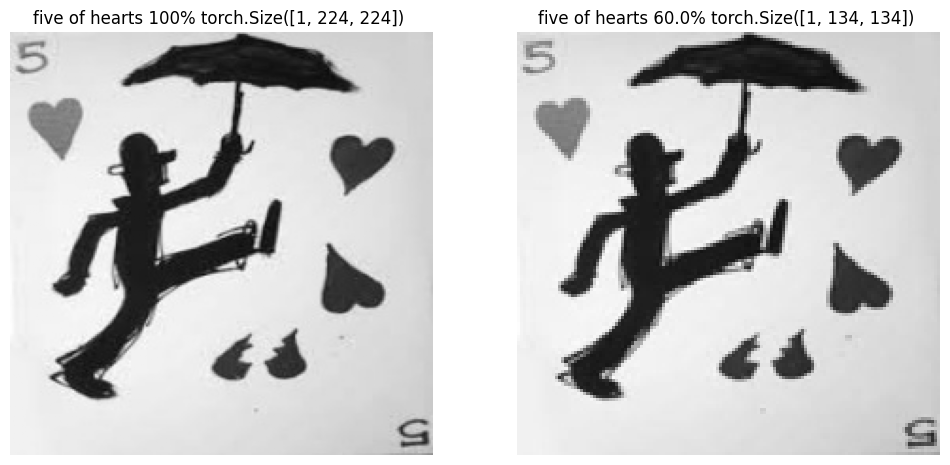

In [4]:
import random
idx = random.randint(0, len(dataset_scale_050))
img_1 , label_1 = dataset_scale_100.__getitem__(idx)
img_2 , label_2 = dataset_scale_050.__getitem__(idx)
Perspectiver.plotComparison(imageBefore = Perspectiver.grayscale_to_rgb(img_1.numpy()[0]) , 
                            imageAfter = Perspectiver.grayscale_to_rgb(img_2.numpy()[0]) , 
                            titleBefore = f"{dataset_scale_100.decode_label(label_1)} {scale_1*100}% {img_1.size()} ",
                            titleAfter = f"{dataset_scale_050.decode_label(label_2)} {scale_2*100}% {img_2.size()} "
                            )

# Training process

## Hyperparameters

In [5]:
EPOCH = 30
BATCH_SIZE = 500
NUN_WORKERS = 8
LR = 0.01

classifier = SupraCardClassifier(convolution_structure=[1,8,8,16,16,32,32,64,64], 
                            image_size=torch.Size((134, 134)), 
                            expert_output_len=8, 
                            extractors_output_len=10,
                            expert_depth=4,
                            output_len=53,
                            n_extractor=2
                            ).to(DEVICE) # 0.52, 20034987

classifier = SupraCardClassifier(convolution_structure=[1,16,16,16,16,32,32,32,32], 
                            image_size=torch.Size((134, 134)), 
                            expert_output_len=8, 
                            extractors_output_len=10,
                            expert_depth=8,
                            output_len=53,
                            n_extractor=2
                            ).to(DEVICE) # 0.35, 5362811

classifier = SupraCardClassifier(convolution_structure=[1,16,16,16,16,32,32,32,32], 
                            image_size=torch.Size((134, 134)), 
                            expert_output_len=15, 
                            extractors_output_len=30,
                            expert_depth=8,
                            output_len=53,
                            n_extractor=2
                            ).to(DEVICE) #0.4264, 6425575

classifier = SupraCardClassifier(convolution_structure=[1,16,16,16,16,32,32,32,32], 
                            image_size=torch.Size((134, 134)), 
                            expert_output_len=15, 
                            extractors_output_len=32,
                            expert_depth=8,
                            output_len=53,
                            n_extractor=2
                            ).to(DEVICE) #0.4764, 6427039

In [6]:
csv_file = "cards.csv"
target = "suit"

train_dataset = CardsDataset(scale=0.6, split="train", csv_file=csv_file, target=target)
test_dataset = CardsDataset(scale=0.6, split="test", csv_file=csv_file, target=target)
valid_dataset = CardsDataset(scale=0.6, split="valid", csv_file=csv_file, target=target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)

_, label = test_dataset.__getitem__(1)

classifier = CardClassifier(image_size=torch.Size((134, 134)), 
                            convolution_structure=[1,8,8,16,16,24,24,32,32],
                            expert_output_len=1,
                            expert_depth=4,
                            output_len=len(label),
                            pool_depth=2
                            ).to(DEVICE)

#classifier = SupraCardClassifier(convolution_structure=[1,8,8,16,16,24,24,32,32], 
#                            image_size=torch.Size((134, 134)), 
#                            expert_output_len=3, 
#                            extractors_output_len=10,
#                            expert_depth=4,
#                            output_len=len(label),
#                            n_extractor=2,
#                            pool_depth=2
#                            ).to(DEVICE)


print(classifier.n_parameters())

2373308


In [7]:
criterion = nn.CrossEntropyLoss(reduction = "sum")

optimizer = optim.Adam(classifier.parameters(), lr=LR)

os.makedirs(f"models/checkpoints/", exist_ok=True)

In [8]:
def save_checkpoint(model, epoch, optimizer, loss, name):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f"models/checkpoints/{name}.pth")

def validation(model, valid_loader, criterion, device):
        valid_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, torch.argmax(labels.to(device), dim=1))
                valid_loss += loss.item() * inputs.size(0)
                
                x, preds = torch.max(outputs, dim=1)
                correct += (preds == torch.argmax(labels.to(device), dim=1)).sum().item()
        
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_prec = correct / len(valid_loader.dataset)

        return valid_loss, valid_prec

In [9]:
def training(model, optimizer, criterion, train_loader, valid_loader, name, device, epochs):
    max_prec = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, torch.argmax(labels.to(device), dim=1))
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        model.eval()
        
        valid_loss, valid_prec = validation(model, valid_loader, criterion, device)
        if valid_prec > max_prec:
            save_checkpoint(model, epoch, optimizer, loss, name)
            max_prec = valid_prec
        
        print(f"EPOCH {epoch+1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {valid_loss:.4f} - Validation Precision: {valid_prec:.4f}")

In [10]:
training(model=classifier, 
         optimizer=optimizer, 
         criterion=criterion,
         train_loader=train_loader,
         valid_loader=valid_loader,
         name="suit_classifier_checkpoint",
         device=DEVICE,
         epochs=EPOCH
         )

EPOCH 1/30 - Training Loss: 774.6395 - Validation Loss: 416.4089 - Validation Precision: 0.2453
EPOCH 2/30 - Training Loss: 772.1842 - Validation Loss: 416.0225 - Validation Precision: 0.2453
EPOCH 3/30 - Training Loss: 771.4785 - Validation Loss: 415.9609 - Validation Precision: 0.2453
EPOCH 4/30 - Training Loss: 770.7211 - Validation Loss: 416.0317 - Validation Precision: 0.2453
EPOCH 5/30 - Training Loss: 770.2586 - Validation Loss: 416.0230 - Validation Precision: 0.2453


KeyboardInterrupt: 

In [ ]:
csv_file = "cards.csv"
target = "category"

train_dataset = CardsDataset(scale=0.6, split="train", csv_file=csv_file, target=target)
test_dataset = CardsDataset(scale=0.6, split="test", csv_file=csv_file, target=target)
valid_dataset = CardsDataset(scale=0.6, split="valid", csv_file=csv_file, target=target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)

_, label = test_dataset.__getitem__(1)

classifier = CardClassifier(image_size=torch.Size((134, 134)), 
                            convolution_structure=[1,8,8,16,16,24,24,32,32],
                            expert_output_len=1,
                            expert_depth=4,
                            output_len=len(label),
                            pool_depth=2
                            ).to(DEVICE)

print(classifier.n_parameters())

2373449


In [ ]:
criterion = nn.CrossEntropyLoss(reduction = "sum")

optimizer = optim.Adam(classifier.parameters(), lr=LR)

training(model=classifier, 
         optimizer=optimizer, 
         criterion=criterion,
         train_loader=train_loader,
         valid_loader=valid_loader,
         name="category_classifier_checkpoint",
         device=DEVICE,
         epochs=(EPOCH*2)
         )

EPOCH 1/4 - Training Loss: 1303.5794 - Validation Loss: 700.7323 - Validation Precision: 0.0755
EPOCH 2/4 - Training Loss: 1295.3761 - Validation Loss: 700.0430 - Validation Precision: 0.0755
EPOCH 3/4 - Training Loss: 1281.9444 - Validation Loss: 699.3646 - Validation Precision: 0.0755
EPOCH 4/4 - Training Loss: 1256.9284 - Validation Loss: 699.1809 - Validation Precision: 0.0755
